In [1]:
import numpy as np
import os
import cv2
from random import shuffle
from tqdm import tqdm

TRAIN_DIR = 'E:/DataSc&ML/Kaggle_Cat_Dog_Data/dogs vs cats/train/train'
TEST_DIR = 'E:/DataSc&ML/Kaggle_Cat_Dog_Data/dogs vs cats/test/test'
IMG_SIZE = 50
LR = 1e-3 #learning rate

MODEL_NAME = 'dogsVscat-{}-{}.model'.format(LR, '6conv_basic')

In [2]:
def label_img(img):
    word_label = img.split('.')[-3] # cat,dog name extration from img name
    if word_label == 'cat': return [1,0]
    elif word_label == 'dog': return [0, 1]

In [3]:
def create_train_data():
    training_data = []
    for img in tqdm(os.listdir(TRAIN_DIR)):
        label = label_img(img)
        path = os.path.join(TRAIN_DIR, img)
        img = cv2.resize( cv2.imread(path, cv2.IMREAD_GRAYSCALE), (IMG_SIZE,IMG_SIZE))
        training_data.append(np.array([np.array(img), np.array(label)]))
    shuffle(training_data)
    np.save('train_data.npy',training_data)
    return training_data

In [4]:
def process_test_data():
    testing_data = []
    for img in tqdm(os.listdir(TEST_DIR)):
        path = os.path.join(TEST_DIR, img)
        img_num = img.split('.')[0]
        img = cv2.resize( cv2.imread(path, cv2.IMREAD_GRAYSCALE), (IMG_SIZE,IMG_SIZE))
        testing_data.append([np.array(img), img_num])
    np.save('test_data.npy', testing_data)
    return testing_data

In [5]:
#train_data = create_train_data()
train_data = np.load('train_data.npy')

In [6]:
import tflearn
from tflearn.layers.conv import conv_2d, max_pool_2d
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.estimator import regression

import tensorflow as tf
tf.reset_default_graph()

convnet = input_data(shape=[None, IMG_SIZE, IMG_SIZE, 1], name='input')

convnet = conv_2d(convnet, 32, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = conv_2d(convnet, 64, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = conv_2d(convnet, 32, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = conv_2d(convnet, 64, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = conv_2d(convnet, 32, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = conv_2d(convnet, 64, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)


convnet = fully_connected(convnet, 1024, activation='relu')
convnet = dropout(convnet, 0.8)

convnet = fully_connected(convnet, 2, activation='softmax')
convnet = regression(convnet, optimizer='adam', learning_rate=LR, loss='categorical_crossentropy', name='targets')

model = tflearn.DNN(convnet, tensorboard_dir = 'log')

E:\Program Files\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


curses is not supported on this machine (please install/reinstall curses for an optimal experience)
Instructions for updating:
Use tf.initializers.variance_scaling instead with distribution=uniform to get equivalent behavior.
Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [7]:
if os.path.exists('{}.meta'.format(MODEL_NAME)):
    model.load(MODEL_NAME)
    print('model loaded')

INFO:tensorflow:Restoring parameters from C:\Users\Dell\DataSc&ML\ML-Sentdex\cat vs dog\dogsVscat-0.001-6conv_basic.model
model loaded


In [8]:
train = train_data[:-500]
test = train_data[-500:]

X = np.array([ i[0] for i in train]).reshape(-1,IMG_SIZE,IMG_SIZE,1)
Y = [ i[1] for i in train]

test_x = np.array([ i[0] for i in test]).reshape(-1,IMG_SIZE,IMG_SIZE,1)
test_y = [ i[1] for i in test]

model.fit({'input': X}, {'targets': Y}, n_epoch=3, validation_set=({'input': test_x}, {'targets': test_y}), 
    snapshot_step=500, show_metric=True, run_id= MODEL_NAME)

Training Step: 2297  | total loss: 0.49128 | time: 119.086s
| Adam | epoch: 003 | loss: 0.49128 - acc: 0.7531 -- iter: 24448/24500
Training Step: 2298  | total loss: 0.49802 | time: 120.398s
| Adam | epoch: 003 | loss: 0.49802 - acc: 0.7528 | val_loss: 0.50122 - val_acc: 0.7580 -- iter: 24500/24500
--


In [9]:
model.save(MODEL_NAME)

INFO:tensorflow:C:\Users\Dell\DataSc&ML\ML-Sentdex\cat vs dog\dogsVscat-0.001-6conv_basic.model is not in all_model_checkpoint_paths. Manually adding it.


[0.8718196  0.12818037]
[0.95686156 0.04313849]
[0.6319523  0.36804774]
[0.1388148 0.8611852]
[0.26870215 0.73129785]
[0.9408483  0.05915174]
[0.91625893 0.08374105]
[0.18113184 0.81886816]
[0.5351103 0.4648898]
[0.98599106 0.01400896]
[0.87548953 0.12451047]
[0.9623147  0.03768524]


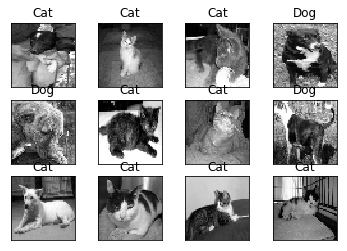

In [12]:
import matplotlib.pyplot as plt

# if you need to create the data:
#test_data = process_test_data()
# if you already have some saved:
test_data = np.load('test_data.npy')

fig=plt.figure()

for num,data in enumerate(test_data[:12]):
    # cat: [1,0]
    # dog: [0,1]
    
    img_num = data[1]
    img_data = data[0]
    
    y = fig.add_subplot(3,4,num+1) # 3by4 matrix
    orig = img_data
    data = img_data.reshape(IMG_SIZE,IMG_SIZE,1)
    #model_out = model.predict([data])[0]
    model_out = model.predict([data])[0]
    print(model_out)
    if np.argmax(model_out) == 1: str_label='Dog'
    else: str_label='Cat'
        
    y.imshow(orig,cmap='gray')
    plt.title(str_label)
    y.axes.get_xaxis().set_visible(False)
    y.axes.get_yaxis().set_visible(False)
plt.show()


In [11]:
with open('submission_file.csv','w') as f:
    f.write('id,label\n')
            
with open('submission_file.csv','a') as f:
    for data in tqdm(test_data):
        img_num = data[1]
        img_data = data[0]
        orig = img_data
        data = img_data.reshape(IMG_SIZE,IMG_SIZE,1)
        model_out = model.predict([data])[0]
        f.write('{},{}\n'.format(img_num,model_out[1]))

100%|██████████| 12500/12500 [01:06<00:00, 187.29it/s]
